In [1]:
import pandas as pd

In [2]:
signal_df = pd.read_csv('NN Project Data - Signal.csv')
signal_df.shape

(1599, 12)

In [3]:
numeric_columns = signal_df.select_dtypes(include=['int', 'float'])
missing_values = numeric_columns.isna().sum()

print("Missing Values in Numeric Columns:")
print(missing_values)

Missing Values in Numeric Columns:
Parameter 1        0
Parameter 2        0
Parameter 3        0
Parameter 4        0
Parameter 5        0
Parameter 6        0
Parameter 7        0
Parameter 8        0
Parameter 9        0
Parameter 10       0
Parameter 11       0
Signal_Strength    0
dtype: int64


In [4]:
signal_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Parameter 1      1599 non-null   float64
 1   Parameter 2      1599 non-null   float64
 2   Parameter 3      1599 non-null   float64
 3   Parameter 4      1599 non-null   float64
 4   Parameter 5      1599 non-null   float64
 5   Parameter 6      1599 non-null   float64
 6   Parameter 7      1599 non-null   float64
 7   Parameter 8      1599 non-null   float64
 8   Parameter 9      1599 non-null   float64
 9   Parameter 10     1599 non-null   float64
 10  Parameter 11     1599 non-null   float64
 11  Signal_Strength  1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


In [5]:
duplicates = signal_df[signal_df.duplicated()]

num_duplicates = len(duplicates)
print(f"Number of duplicate rows: {num_duplicates}")

Number of duplicate rows: 240


In [6]:
signal_df_cleaned = signal_df.drop_duplicates()  # Remove duplicate rows
signal_df_imputed = signal_df_cleaned.fillna(signal_df_cleaned.mean()) 
signal_df = signal_df_imputed

In [7]:
def replace_outliers_with_mean_or_median(df, column, method='median', threshold=1.5):
    if method == 'median':
        # Calculate the median
        median = df[column].median()
        # Calculate the IQR
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        # Set the boundaries
        lower_bound = Q1 - threshold * IQR
        upper_bound = Q3 + threshold * IQR
        # Replace outliers with median
        df[column] = df[column].apply(lambda x: median if x < lower_bound or x > upper_bound else x)
    elif method == 'mean':
        # Calculate the mean
        mean = df[column].mean()
        # Calculate the standard deviation
        std = df[column].std()
        # Set the boundaries
        lower_bound = mean - threshold * std
        upper_bound = mean + threshold * std
        # Replace outliers with mean
        df[column] = df[column].apply(lambda x: mean if x < lower_bound or x > upper_bound else x)
    return df


In [8]:
for column in signal_df.columns:
    signal_df = replace_outliers_with_mean_or_median(signal_df, column, method='median')
signal_df.shape

(1359, 12)

C:\Users\Admin\anaconda3.1\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


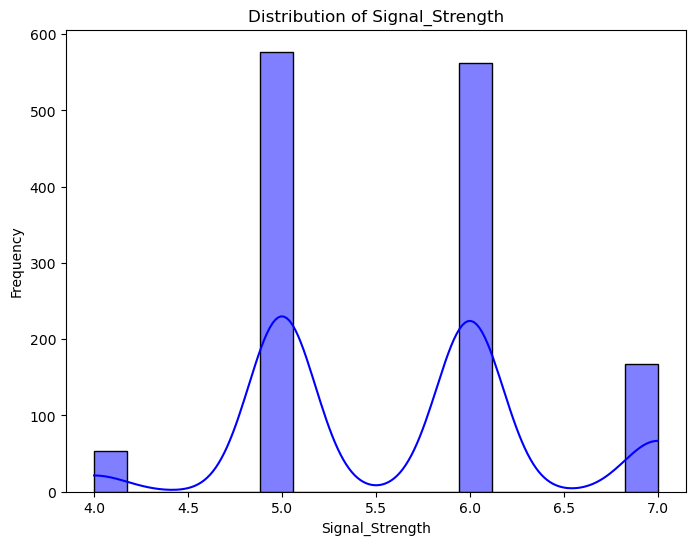

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

target_variable = "Signal_Strength"

plt.figure(figsize=(8, 6))
sns.histplot(signal_df[target_variable], kde=True, color='blue')
plt.title(f'Distribution of {target_variable}')
plt.xlabel(target_variable)
plt.ylabel('Frequency')
plt.show()


<Figure size 3000x2000 with 0 Axes>

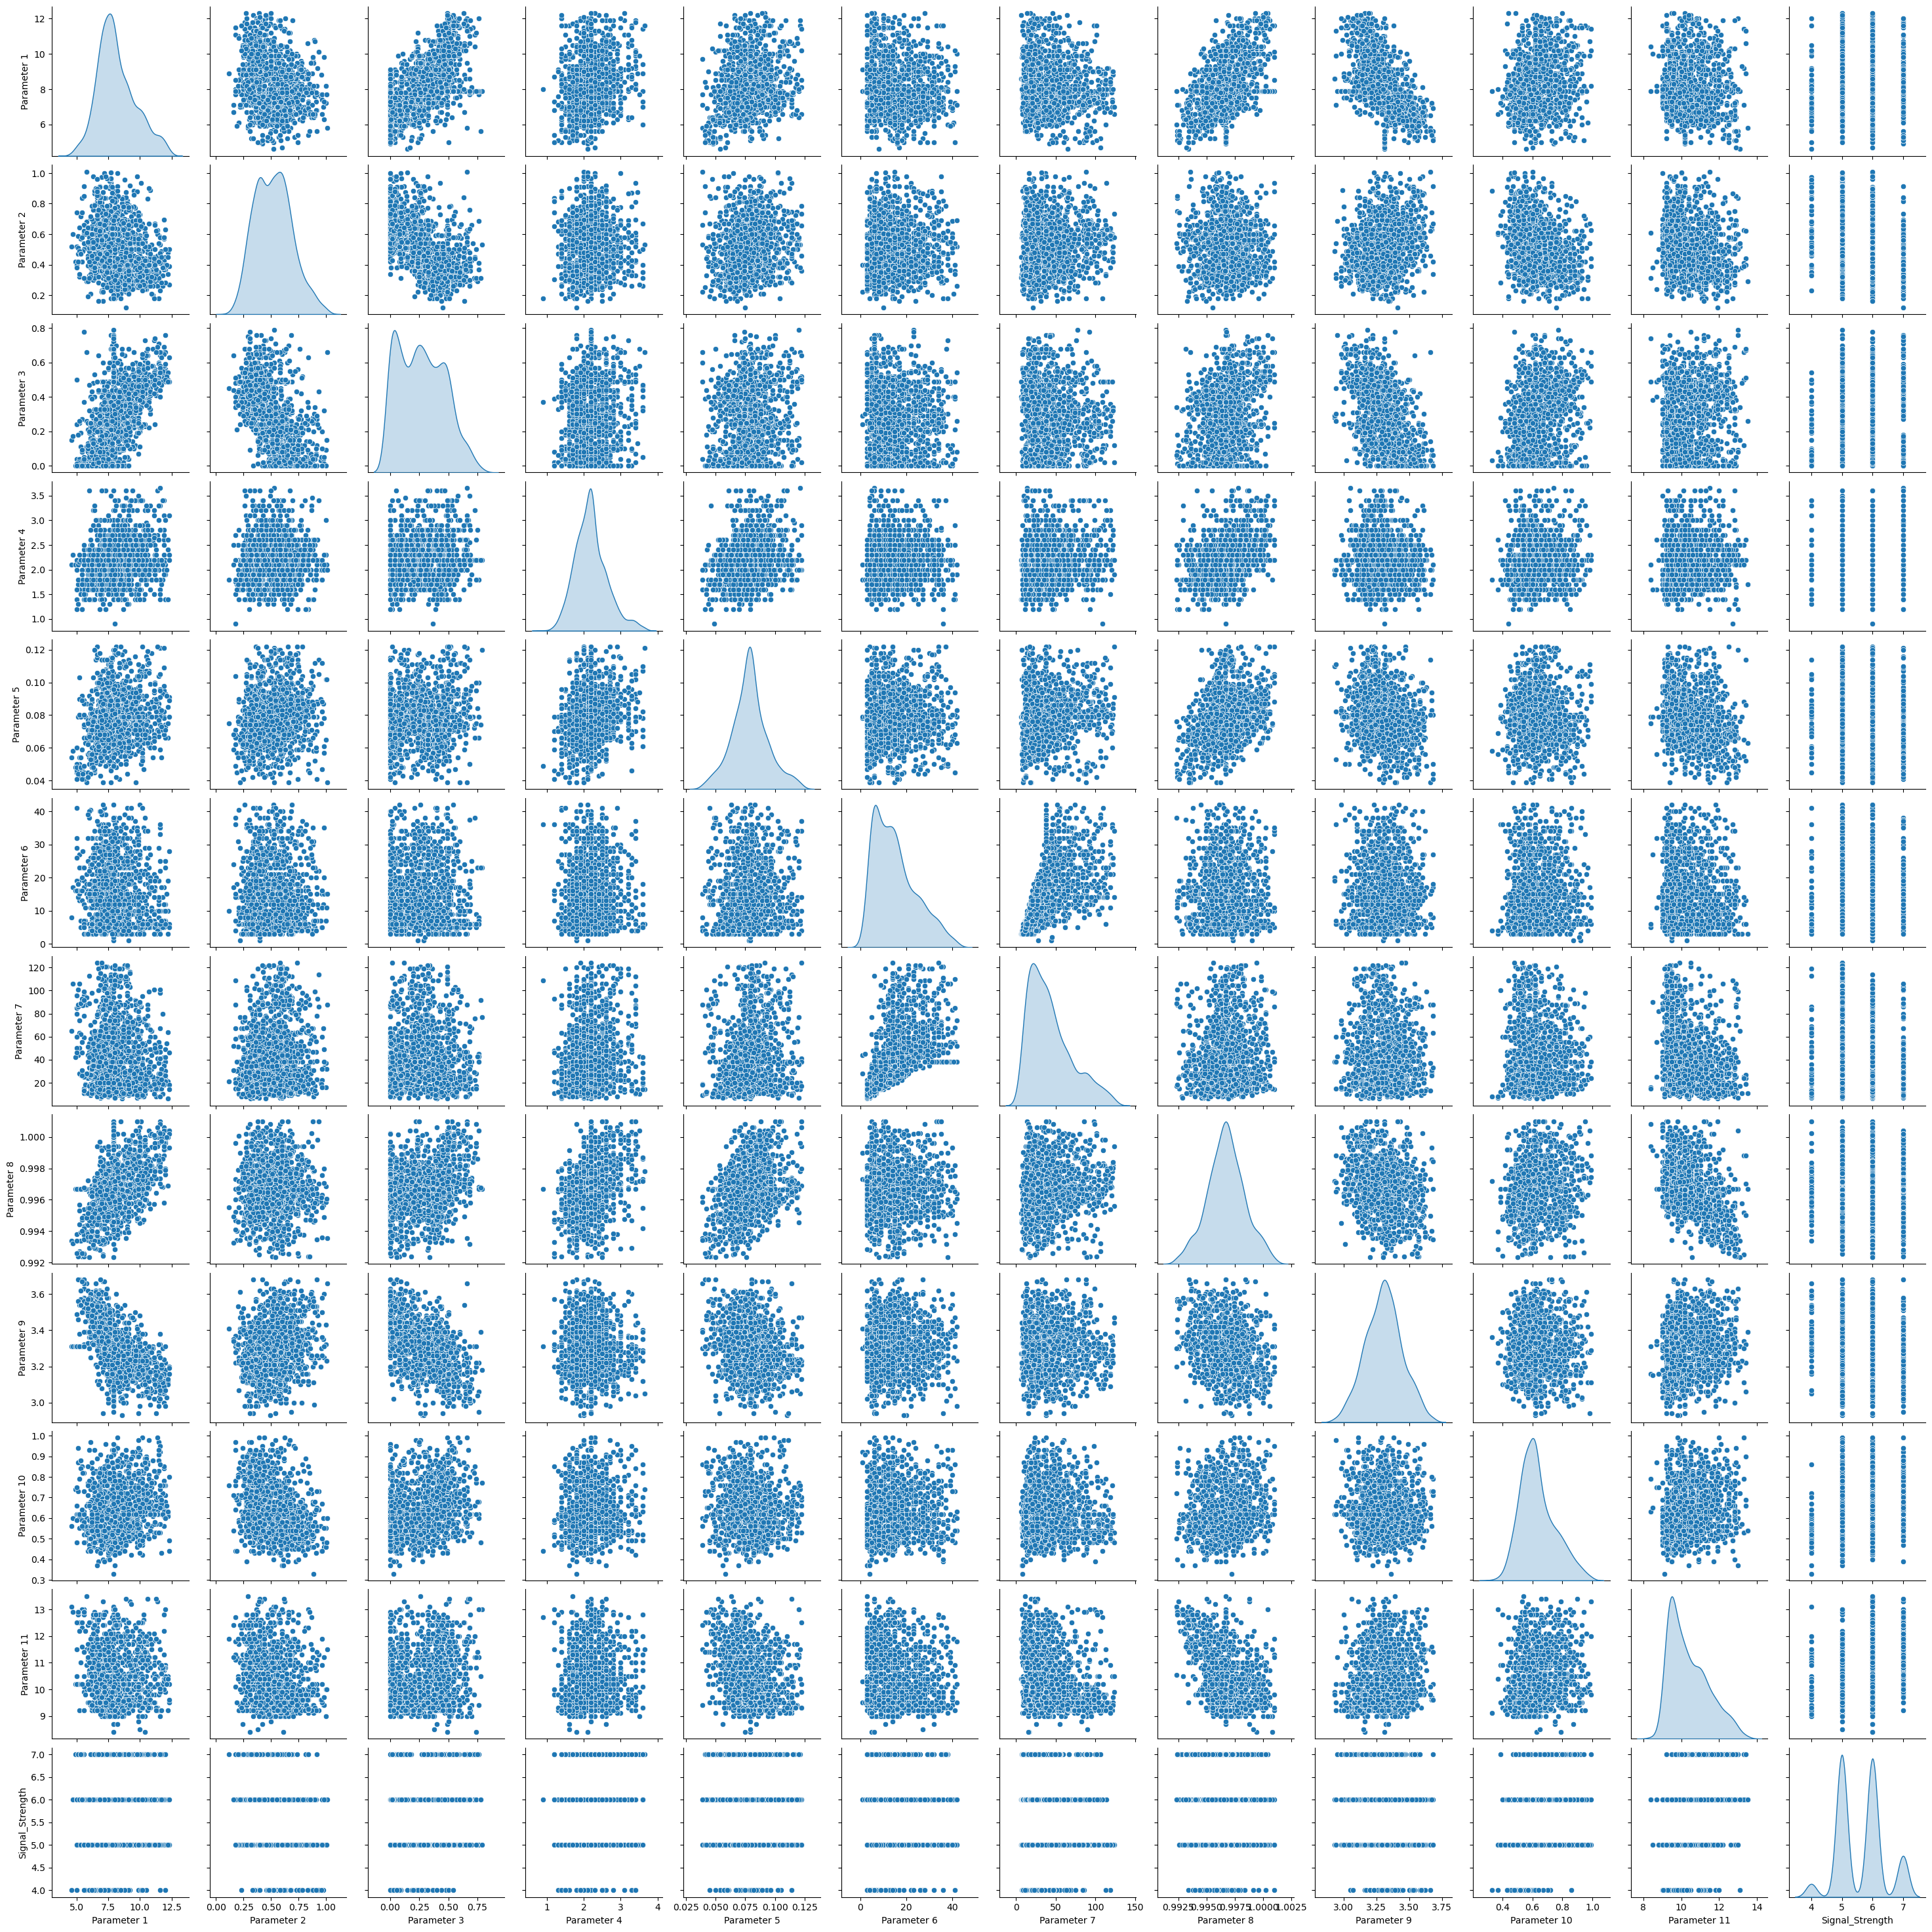

In [10]:
plt.figure(figsize=(30, 20))
sns.pairplot(signal_df,diag_kind='kde')
plt.show()

In [11]:
Y = signal_df["Signal_Strength"]
X = signal_df.drop("Signal_Strength", axis=1)

In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

In [13]:
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("Y_train shape:", Y_train.shape)
print("Y_test shape:", Y_test.shape)

if X_train.shape[0] + X_test.shape[0] == X.shape[0] and Y_train.shape[0] + Y_test.shape[0] == Y.shape[0]:
    print("Train and test data are in sync.")
else:
    print("Train and test data are not in sync.")


X_train shape: (951, 11)
X_test shape: (408, 11)
Y_train shape: (951,)
Y_test shape: (408,)
Train and test data are in sync.


In [14]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_normalized = scaler.fit_transform(X_train)
X_test_normalized = scaler.transform(X_test)


In [15]:
signal_df['Signal_Strength'].value_counts()

5.0    577
6.0    562
7.0    167
4.0     53
Name: Signal_Strength, dtype: int64

In [16]:
# Using one-hot encoding on target variable
Y_train = pd.get_dummies(Y_train)
Y_test = pd.get_dummies(Y_test)
print(Y_train.shape)
print(Y_test.shape)

(951, 4)
(408, 4)


In [17]:
from tensorflow import keras
from tensorflow.keras import layers

# Create a neural network model
model = keras.Sequential()

# Add input and hidden layers
model.add(layers.Input(shape=(X_train_normalized.shape[1],)))

# Add one or more hidden layers with activation functions
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
num_classes = 4  
model.add(layers.Dense(num_classes, activation='softmax'))

# Compile the model with appropriate loss and optimizer
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

# Train the model using the one-hot encoded target variable
history_old = model.fit(X_train_normalized, Y_train, epochs=10,validation_data=(X_test_normalized, Y_test))

# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(X_test_normalized, Y_test)
print(f"Test Accuracy: {test_accuracy}")


Epoch 1/10
30/30 [==============================] - 1s 10ms/step - loss: 1.2842 - accuracy: 0.3964 - val_loss: 1.1089 - val_accuracy: 0.5343
Epoch 2/10
30/30 [==============================] - 0s 4ms/step - loss: 1.0571 - accuracy: 0.5563 - val_loss: 0.9730 - val_accuracy: 0.5907
Epoch 3/10
30/30 [==============================] - 0s 5ms/step - loss: 0.9714 - accuracy: 0.5773 - val_loss: 0.9089 - val_accuracy: 0.6005
Epoch 4/10
30/30 [==============================] - 0s 4ms/step - loss: 0.9345 - accuracy: 0.5836 - val_loss: 0.8875 - val_accuracy: 0.6029
Epoch 5/10
30/30 [==============================] - 0s 5ms/step - loss: 0.9149 - accuracy: 0.5931 - val_loss: 0.8782 - val_accuracy: 0.6005
Epoch 6/10
30/30 [==============================] - 0s 5ms/step - loss: 0.9018 - accuracy: 0.5973 - val_loss: 0.8731 - val_accuracy: 0.6054
Epoch 7/10
30/30 [==============================] - 0s 5ms/step - loss: 0.8898 - accuracy: 0.6025 - val_loss: 0.8718 - val_accuracy: 0.5931
Epoch 8/10
30/30 [=

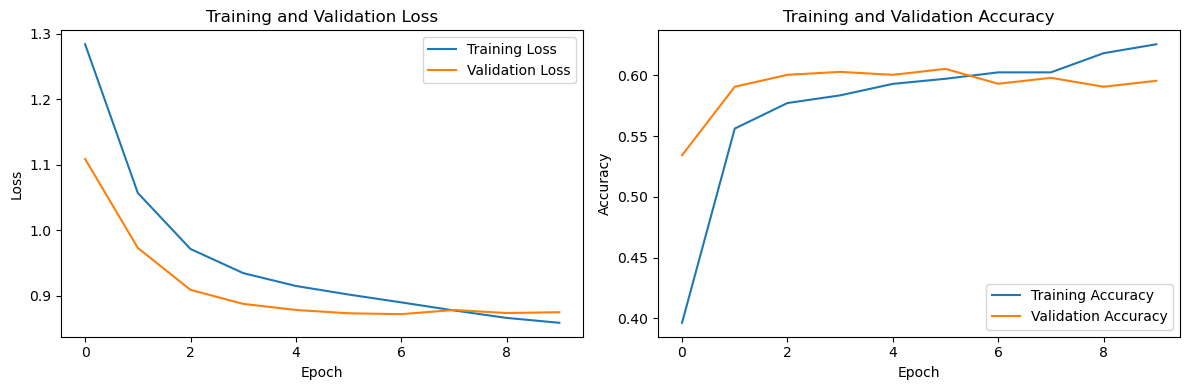

In [18]:
import matplotlib.pyplot as plt

# Extract the training and validation metrics from the model's history
training_loss = history_old.history['loss']
validation_loss = history_old.history['val_loss']
training_accuracy = history_old.history['accuracy']
validation_accuracy = history_old.history['val_accuracy']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.set_title('Training and Validation Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.plot(training_loss, label='Training Loss')
ax1.plot(validation_loss, label='Validation Loss')
ax1.legend()

ax2.set_title('Training and Validation Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.plot(training_accuracy, label='Training Accuracy')
ax2.plot(validation_accuracy, label='Validation Accuracy')
ax2.legend()

plt.tight_layout()
plt.show()

In [19]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler

# Define a learning rate schedule
def lr_schedule(epoch):
    initial_lr = 0.001
    if epoch < 10:
        return initial_lr
    else:
        return initial_lr * 0.9

learning_rate_scheduler = LearningRateScheduler(lr_schedule)

model2 = keras.Sequential()

model2.add(layers.BatchNormalization())


model2.add(layers.Dense(4, activation='softmax'))

model2.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

# Implement early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)

history_new = model2.fit(X_train_normalized, Y_train, epochs=150, batch_size=20, validation_data=(X_test_normalized, Y_test), callbacks=[early_stopping, learning_rate_scheduler])

test_loss, test_accuracy = model2.evaluate(X_test_normalized, Y_test)
print(f"Test Accuracy: {test_accuracy}")


Epoch 1/150
48/48 [==============================] - 1s 7ms/step - loss: 2.1058 - accuracy: 0.2061 - val_loss: 2.0478 - val_accuracy: 0.2181 - lr: 0.0010
Epoch 2/150
48/48 [==============================] - 0s 4ms/step - loss: 1.8612 - accuracy: 0.2461 - val_loss: 1.8230 - val_accuracy: 0.2475 - lr: 0.0010
Epoch 3/150
48/48 [==============================] - 0s 4ms/step - loss: 1.6758 - accuracy: 0.2776 - val_loss: 1.6410 - val_accuracy: 0.2892 - lr: 0.0010
Epoch 4/150
48/48 [==============================] - 0s 5ms/step - loss: 1.5300 - accuracy: 0.3207 - val_loss: 1.4996 - val_accuracy: 0.3260 - lr: 0.0010
Epoch 5/150
48/48 [==============================] - 0s 5ms/step - loss: 1.4177 - accuracy: 0.3638 - val_loss: 1.3867 - val_accuracy: 0.3603 - lr: 0.0010
Epoch 6/150
48/48 [==============================] - 0s 5ms/step - loss: 1.3447 - accuracy: 0.3943 - val_loss: 1.2961 - val_accuracy: 0.4093 - lr: 0.0010
Epoch 7/150
48/48 [==============================] - 0s 5ms/step - loss: 1.2

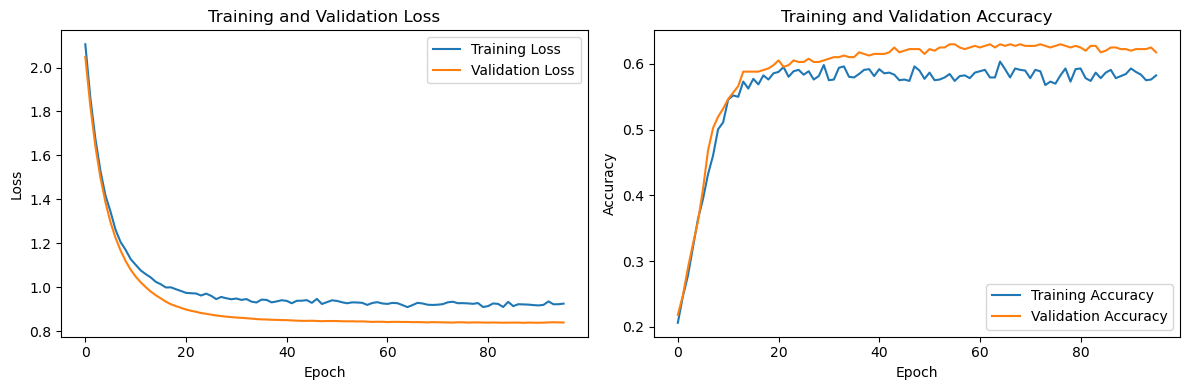

In [20]:
training_loss = history_new.history['loss']
validation_loss = history_new.history['val_loss']
training_accuracy = history_new.history['accuracy']
validation_accuracy = history_new.history['val_accuracy']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.set_title('Training and Validation Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.plot(training_loss, label='Training Loss')
ax1.plot(validation_loss, label='Validation Loss')
ax1.legend()

ax2.set_title('Training and Validation Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.plot(training_accuracy, label='Training Accuracy')
ax2.plot(validation_accuracy, label='Validation Accuracy')
ax2.legend()

plt.tight_layout()
plt.show()

In [21]:
val_loss_model1, val_acc_model1 = model.evaluate(X_test_normalized, Y_test)
val_loss_model2, val_acc_model2 = model2.evaluate(X_test_normalized, Y_test)
# Compare validation metrics
if val_acc_model1 > val_acc_model2:
    print("Model 1 has a higher validation accuracy.")
else:
    print("Model 2 has a higher validation accuracy.")

if val_loss_model1 < val_loss_model2:
    print("Model 1 has a lower validation loss.")
else:
    print("Model 2 has a lower validation loss.")

13/13 [==============================] - 0s 3ms/step - loss: 0.8384 - accuracy: 0.6250
Model 2 has a higher validation accuracy.
Model 2 has a lower validation loss.


In [22]:
import h5py

file_path = 'Autonomous_Vehicles_SVHN_single_grey1.h5'

with h5py.File(file_path, 'r') as file:
    # Define a function to recursively print all keys
    def print_all_keys(name, obj):
        if isinstance(obj, h5py.Group):
            print(f"Group: {name}")
        else:
            print(f"Dataset: {name}")

    # Visit all items in the HDF5 file and call the function
    file.visititems(print_all_keys)

Dataset: X_test
Dataset: X_train
Dataset: X_val
Dataset: y_test
Dataset: y_train
Dataset: y_val


In [23]:
import h5py
import numpy as np

file_path = 'Autonomous_Vehicles_SVHN_single_grey1.h5' 

with h5py.File(file_path, 'r') as file:
    X_test = np.array(file['X_test'])
    X_train = np.array(file['X_train'])
    X_val = np.array(file['X_val'])
    y_test = np.array(file['y_test'])
    y_train = np.array(file['y_train'])
    y_val = np.array(file['y_val'])


C:\Users\Admin\AppData\Local\Temp\ipykernel_2192\3265996366.py:7: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  X_test = np.array(file['X_test'])
C:\Users\Admin\AppData\Local\Temp\ipykernel_2192\3265996366.py:8: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  X_train = np.array(file['X_train'])
C:\Users\Admin\AppData\Local\Temp\ipykernel_2192\3265996366.py:9: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  X_val = np.array(file['X_val'])
C:\Users\Admin\AppData\Local\Temp\ipykernel_2192\3265996366.py:10: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  y_test = np.array(file['y_test'])
C:\Users\Admin\AppData\Local\Temp\ipykernel_2192\3265996366.py:11: DeprecationWarning: `pro

In [24]:
total_samples = len(X_train) + len(X_test)
train_percentage = len(X_train) / total_samples * 100
test_percentage = len(X_test) / total_samples * 100

print(f"Training set percentage: {train_percentage:.2f}%")
print(f"Testing set percentage: {test_percentage:.2f}%")


Training set percentage: 70.00%
Testing set percentage: 30.00%


In [25]:
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

# Verify that the shapes of X and y match
assert X_train.shape[0] == y_train.shape[0], "X and y shapes don't match in training set"
assert X_test.shape[0] == y_test.shape[0], "X and y shapes don't match in testing set"


X_train shape: (42000, 32, 32)
X_test shape: (18000, 32, 32)
y_train shape: (42000,)
y_test shape: (18000,)


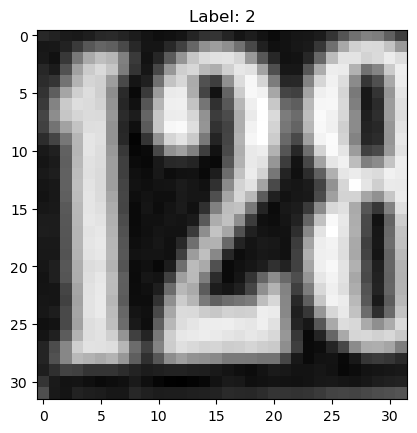

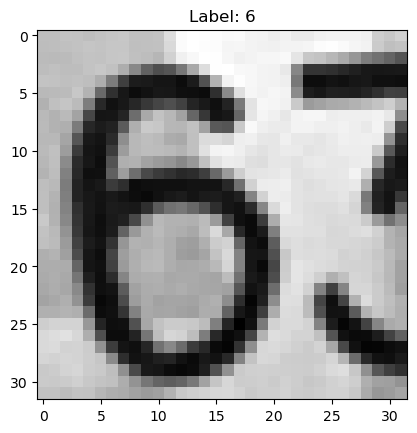

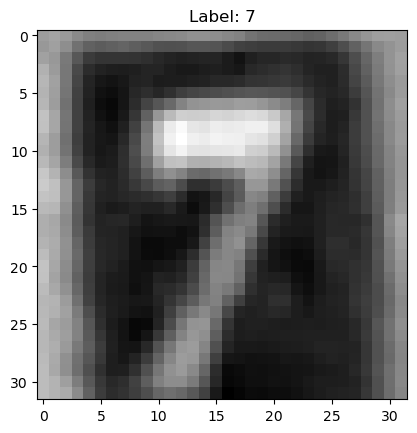

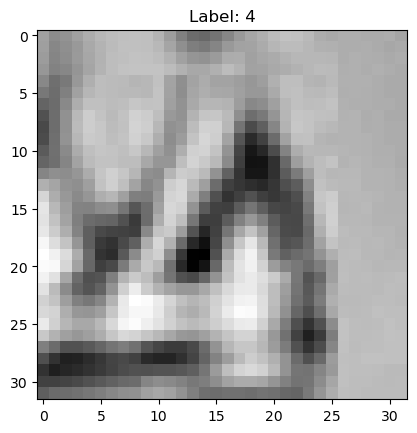

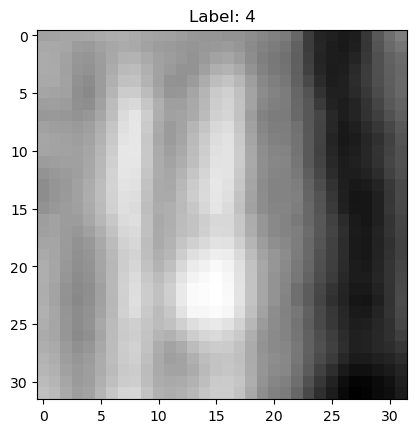

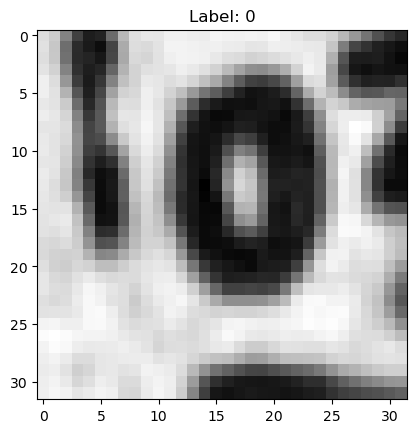

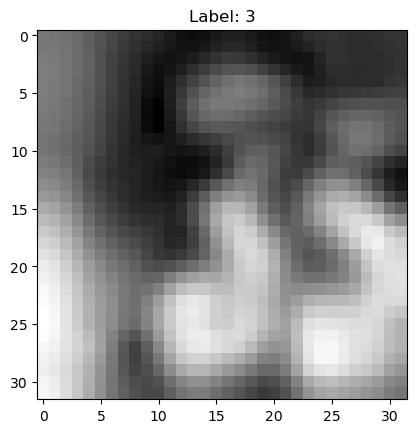

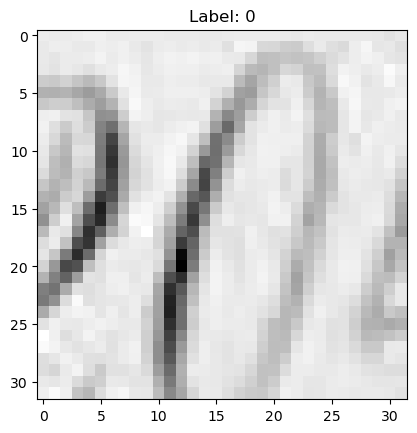

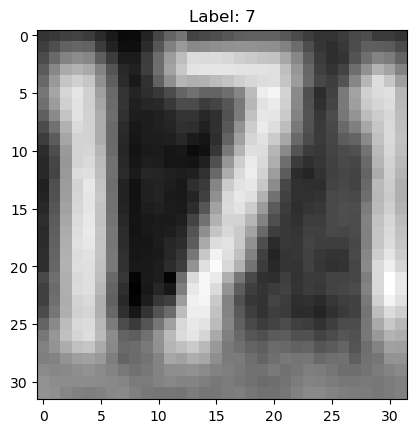

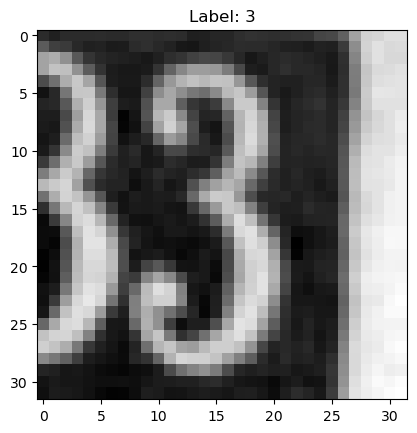

In [26]:
# Iterate through the first 10 images and labels
for i in range(10):
    image = X_train[i]  # Get the i-th image
    label = y_train[i]  # Get the i-th label

    # Display the image
    plt.figure()
    plt.imshow(image, cmap='gray')  
    plt.title(f"Label: {label}")
    plt.show()


In [27]:
# Flatten the images
image_vector_size = 32*32
x_train = X_train.reshape(X_train.shape[0], image_vector_size)
x_test = X_test.reshape(X_test.shape[0], image_vector_size)

# # normalize inputs from 0-255 to 0-1
X_train = X_train / 255.0
X_test = X_test / 255.0

print('Training set', X_train.shape, y_train.shape)
print('Test set', X_test.shape, y_test.shape)

Training set (42000, 32, 32) (42000,)
Test set (18000, 32, 32) (18000,)


In [28]:
from tensorflow.keras.utils import to_categorical
# Convert to "one-hot" vectors using the to_categorical function
num_classes = 10
y_train = to_categorical(y_train, num_classes)
y_test_cat=to_categorical(y_test,num_classes)

In [29]:
num_classes = len(np.unique(y_train))

print("Total number of classes in the dataset:", num_classes)

Total number of classes in the dataset: 2


In [30]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import optimizers
# Create model
image_size = 32*32 #Image size was found to be 32*32
model = Sequential()

model.add(Dense(256, activation='relu', kernel_initializer='he_uniform', input_shape=(image_size,)))
model.add(BatchNormalization())
model.add(Dense(64, activation='relu', kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Dense(64, activation='relu', kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Dense(32, activation='relu', kernel_initializer='he_uniform'))
model.add(Dropout(0.3))

model.add(Dense(10, activation='softmax'))

adam = Adam(learning_rate=1e-3)
model.compile(loss=CategoricalCrossentropy(), optimizer=adam, metrics=['accuracy'])

checkpoint = ModelCheckpoint("model_weights.h5", monitor='val_accuracy', save_weights_only=True, mode='max', verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=0.00001, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)

callbacks = [checkpoint, reduce_lr, early_stopping]

history = model.fit(x_train, y_train, validation_split=0.2, epochs=10, batch_size=128, verbose=2, callbacks=callbacks)


Epoch 1/10

Epoch 1: saving model to model_weights.h5
263/263 - 5s - loss: 2.0056 - accuracy: 0.3026 - val_loss: 1.8116 - val_accuracy: 0.3743 - lr: 0.0010 - 5s/epoch - 21ms/step
Epoch 2/10

Epoch 2: saving model to model_weights.h5
263/263 - 6s - loss: 1.3567 - accuracy: 0.5595 - val_loss: 1.7638 - val_accuracy: 0.4024 - lr: 0.0010 - 6s/epoch - 21ms/step
Epoch 3/10

Epoch 3: saving model to model_weights.h5
263/263 - 30s - loss: 1.1611 - accuracy: 0.6312 - val_loss: 1.4934 - val_accuracy: 0.4983 - lr: 0.0010 - 30s/epoch - 115ms/step
Epoch 4/10

Epoch 4: saving model to model_weights.h5
263/263 - 4s - loss: 1.0553 - accuracy: 0.6708 - val_loss: 1.3107 - val_accuracy: 0.5638 - lr: 0.0010 - 4s/epoch - 16ms/step
Epoch 5/10

Epoch 5: saving model to model_weights.h5
263/263 - 4s - loss: 0.9814 - accuracy: 0.6945 - val_loss: 1.4866 - val_accuracy: 0.5421 - lr: 0.0010 - 4s/epoch - 14ms/step
Epoch 6/10

Epoch 6: saving model to model_weights.h5

Epoch 6: ReduceLROnPlateau reducing learning ra

In [31]:
# predicting the model on test data
y_pred=model.predict(x_test)

563/563 [==============================] - 2s 3ms/step


In [32]:
y_pred[0]

array([0.3143543 , 0.04093155, 0.08879722, 0.04775522, 0.04015042,
       0.03665829, 0.09418209, 0.03209357, 0.15201089, 0.15306646],
      dtype=float32)

In [33]:
# As our outputs are probabilities so we will try to get the output class from these probablities by getting the maximum value
y_pred_final=[]
for i in y_pred:
  y_pred_final.append(np.argmax(i))

In [34]:
y_pred_final[0]

0

In [35]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred_final))

              precision    recall  f1-score   support

           0       0.82      0.81      0.81      1814
           1       0.75      0.84      0.79      1828
           2       0.81      0.79      0.80      1803
           3       0.73      0.72      0.72      1719
           4       0.83      0.82      0.83      1812
           5       0.74      0.78      0.76      1768
           6       0.79      0.79      0.79      1832
           7       0.81      0.81      0.81      1808
           8       0.78      0.71      0.75      1812
           9       0.75      0.74      0.74      1804

    accuracy                           0.78     18000
   macro avg       0.78      0.78      0.78     18000
weighted avg       0.78      0.78      0.78     18000



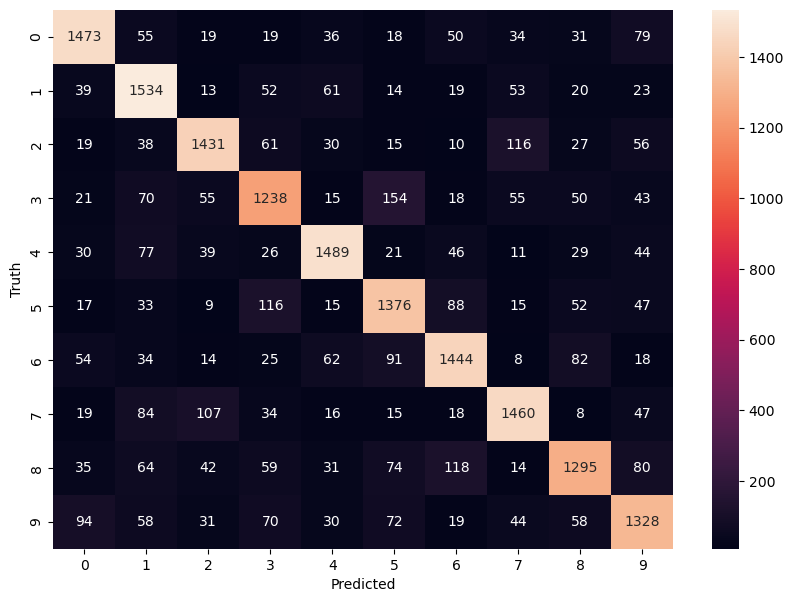

In [36]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm=confusion_matrix(y_test,y_pred_final)

plt.figure(figsize=(10,7))
sns.heatmap(cm,annot=True,fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

In [37]:
index = 0
misclassified_images = []
for label, predict in zip(y_test, y_pred_final):
    if label != predict: 
        misclassified_images.append(index)
    index +=1
print(misclassified_images)
print(len(misclassified_images))

[0, 1, 7, 8, 11, 12, 18, 23, 25, 26, 27, 29, 40, 45, 46, 56, 58, 64, 67, 68, 79, 89, 90, 92, 97, 100, 108, 109, 114, 132, 136, 137, 138, 140, 142, 149, 150, 151, 154, 155, 158, 159, 176, 182, 183, 184, 185, 186, 188, 194, 199, 203, 210, 215, 222, 223, 228, 230, 232, 246, 251, 252, 253, 267, 268, 270, 274, 278, 300, 303, 304, 307, 323, 346, 347, 351, 355, 360, 363, 370, 372, 374, 380, 396, 398, 402, 403, 404, 407, 411, 415, 418, 426, 432, 434, 437, 446, 448, 450, 451, 456, 457, 485, 489, 490, 496, 497, 498, 500, 503, 504, 505, 507, 510, 514, 516, 520, 523, 524, 527, 529, 530, 532, 535, 537, 543, 550, 551, 556, 560, 562, 563, 586, 590, 592, 612, 619, 620, 624, 630, 633, 640, 648, 652, 663, 664, 665, 671, 672, 690, 691, 694, 700, 704, 706, 715, 717, 728, 738, 753, 760, 768, 771, 777, 780, 783, 784, 787, 795, 809, 811, 813, 815, 838, 843, 849, 856, 859, 860, 865, 867, 869, 871, 872, 873, 875, 882, 887, 889, 891, 895, 896, 907, 909, 926, 935, 941, 942, 946, 948, 949, 951, 954, 955, 956, 965

1/1 [==============================] - 0s 24ms/step
Was predicted  3
Was labeled  3
Predicted Probabilities:  [[1.2232414e-07 4.0666713e-05 5.0872484e-05 9.9449545e-01 3.3990707e-06
  4.3174629e-03 3.8814588e-07 1.3073485e-05 2.7437246e-04 8.0425397e-04]]


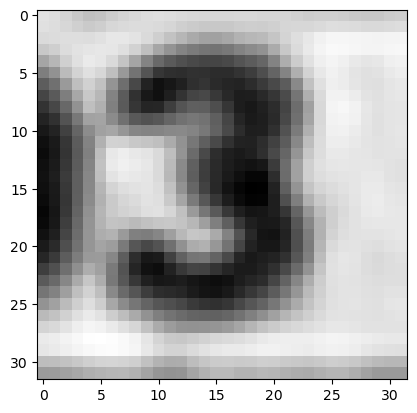

In [38]:
image_index = 445
plt.imshow(x_test[image_index].reshape(32,32),cmap='Greys')
pred = model.predict(x_test[image_index].reshape(-1, 1024))
print("Was predicted ",pred.argmax())
print("Was labeled ",y_test[image_index])
print("Predicted Probabilities: ",pred)

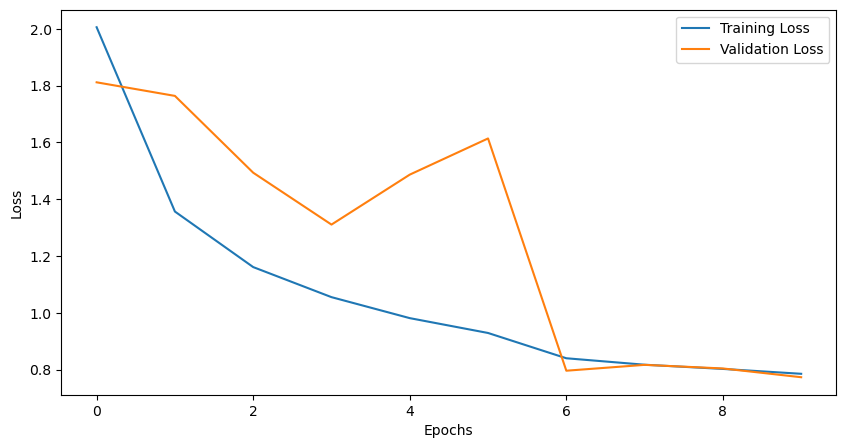

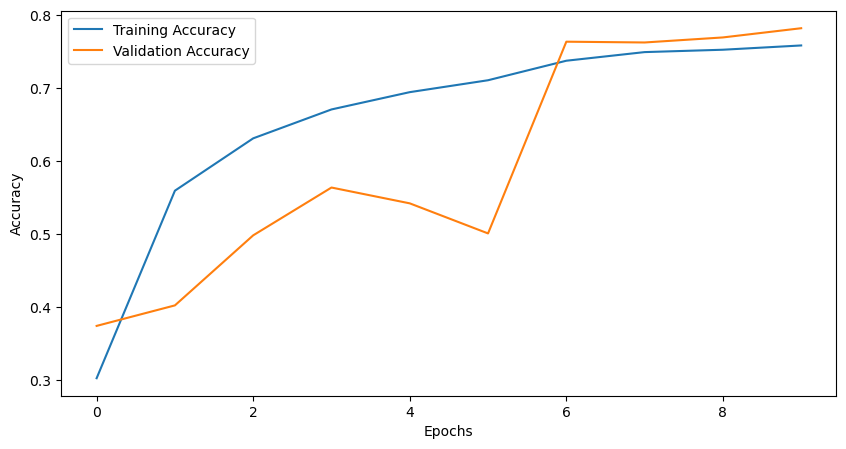

Final Training Loss: 0.7854
Final Validation Loss: 0.7734
Final Training Accuracy: 0.7584
Final Validation Accuracy: 0.7820


In [40]:
training_loss = history.history['loss']  
validation_loss = history.history['val_loss'] 
training_accuracy = history.history['accuracy']  
validation_accuracy = history.history['val_accuracy']  


import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(training_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(training_accuracy, label='Training Accuracy')
plt.plot(validation_accuracy, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

final_training_loss = training_loss[-1]
final_validation_loss = validation_loss[-1]
final_training_accuracy = training_accuracy[-1]
final_validation_accuracy = validation_accuracy[-1]

print(f'Final Training Loss: {final_training_loss:.4f}')
print(f'Final Validation Loss: {final_validation_loss:.4f}')
print(f'Final Training Accuracy: {final_training_accuracy:.4f}')
print(f'Final Validation Accuracy: {final_validation_accuracy:.4f}')
